# Exploratory Data Analysis

Setting the workspace by mounting my drive to have access to my drive files

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Set the path to the directory containing the datasets
path = ''

In [ ]:
!pip install datasets

In [ ]:
from transformers import AutoTokenizer

model_checkpoint = "facebook/bart-base"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [ ]:
import pandas as pd
eLife_test = pd.read_json(path+'/eLife_test.jsonl', lines=True)

In [ ]:
# Print a sample of an article

eLife_test.iloc[0].article

Here we experiment with the tokenizer to see the inputs and the resulting outputs.

In [ ]:
text = "Acylation of diverse carbohydrates occurs across all domains of life ."

In [ ]:
inputs = tokenizer(text)
inputs

{'input_ids': [0, 250, 4469, 35019, 9, 5544, 34215, 11493, 420, 70, 30700, 9, 301, 479, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
tokenizer.convert_ids_to_tokens(inputs.input_ids)

['<s>',
 'A',
 'cy',
 'lation',
 'Ġof',
 'Ġdiverse',
 'Ġcarbohydrates',
 'Ġoccurs',
 'Ġacross',
 'Ġall',
 'Ġdomains',
 'Ġof',
 'Ġlife',
 'Ġ.',
 '</s>']

# Import of libraries

In [ ]:
import pandas as pd
import json
import random
from IPython.display import display, HTML

import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import sent_tokenize
from nltk.probability import FreqDist

import re

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Function definitions

In [ ]:
def print_dataset_info(dataset):
  train = (dataset['split'] == 'train')
  test = (dataset['split'] == 'test')
  validation = (dataset['split'] == 'val')
  PLOS = (dataset['dataset'] == 'PLOS')
  eLife = (dataset['dataset'] == 'eLife')

  print(f"For PLOS we have the following Number of samples:\n"
      f"  - Training: {len(dataset[train & PLOS])}\n"
      f"  - Testing: {len(dataset[test & PLOS])}\n"
      f"  - Validation: {len(dataset[validation & PLOS])}\n")
  print(f"For the eLife we have the following Number of samples:\n"
      f"  - Training: {len(dataset[train & eLife])}\n"
      f"  - Testing: {len(dataset[test & eLife])}\n"
      f"  - Validation: {len(dataset[validation & eLife])}")


def display_text(title, text, article=False, headings=[]):
  display(HTML(f"<h1>{title}</h1>\n"))

  if not article:
      display(HTML(f"<p>{text}</p>\n"))

  else:
    html_content = ''
    paragraphs = text.split('\n')

    for heading, paragraph in zip(headings, paragraphs):
      html_content += f"<h3>{heading}</h3>\n"
      html_content += f"<p>{paragraph}</p>\n"

    display(HTML(html_content))

def print_sample(dataset, idx=-1):
  if idx == -1:
    idx = random.randint(0, len(dataset))
    article = dataset.iloc[idx]
  else:
    article = dataset.iloc[idx]

  display_text(f"Article {idx} - ID: {article.id}", text=article.article, article=True, headings=article.headings)

  display_text('Keywords', article.keywords, article=False)

  display_text('Lay summary', article.lay_summary, article=False)

def remove_references(text):
  if pd.notnull(text):
    ref_pattern = r'(\(\s*[A-Za-z]+(?:\s+and\s+[A-Za-z]+)*\s*,\s*\d{4}[a-z]?\s*\))|\[\s*\d+\s*(?:,\s*\d+\s*)*\]|\(Figure\s*\d+[a-z]?\s*\)'

    return re.sub(ref_pattern, '', text)
  else:
    return text

def compute_sentence_stats(text):
  """ Input: text
      Output: number of sentences, maximum, minimum and average sentence length
  """
  if pd.notnull(text):
    sentences = sent_tokenize(text)
    if sentences:
      sentence_lengths = [len(sentence.split()) for sentence in sentences]
      return {
        'count': len(sentences), 'max_length': max(sentence_lengths),
        'min_length': min(sentence_lengths), 'mean_length': sum(sentence_lengths) / len(sentence_lengths)
      }
    else:
      return {
        'count': 0, 'max_length': 0, 'min_length': 0, 'mean_length': 0
      }
  else:
    return {
      'count': None, 'max_length': None, 'min_length': None, 'mean_length': None
    }

def compute_word_stats(text):
  tokenizer = RegexpTokenizer(r'\w+')

  if pd.notnull(text):
    tokens = tokenizer.tokenize(text)
    if tokens:
      mean_word_length = sum(len(word) for word in tokens) / len(tokens)
      max_word_length = max(len(word) for word in tokens)
    else:
      mean_word_length = max_word_length = 0

    return {
      'count': len(tokens), 'max_length': max_word_length, 'mean_length': mean_word_length
    }
  else:
    return {
      'count': None, 'max_length': None, 'mean_length': None
    }

def plot_statistics(dataset):
  palette_name = 'Set3'
  colors = sns.color_palette(palette_name)
  cols = len(dataset.columns)

  fig, axs = plt.subplots(1, cols, figsize=(20, 5))

  for i, (column, color) in enumerate(zip(dataset.columns, colors)):
        sns.histplot(dataset[column], bins=25, color=color, kde=True, ax=axs[i])
        axs[i].set_xlabel(column.capitalize().replace('_', ' '))
        axs[i].set_ylabel('Frequency')
        axs[i].set_title(f'Distribution of {column.capitalize().replace("_", " ")}')

  plt.tight_layout()

  plt.show()

def extract_unique_words(text):
  tokenizer = RegexpTokenizer(r'\w+')

  if pd.notnull(text):
    return FreqDist(word for word in tokenizer.tokenize(text.lower()))
  else:
     return {}

def extract_abstract(article):
  return article.split('\n')[0]

# Data Exploration

## Number of instances

First we will read the data and join the two datasets in one.

In [ ]:
PLOS_train = pd.read_json(path+'/PLOS_train.jsonl', lines=True)
PLOS_test = pd.read_json(path+'/PLOS_test.jsonl', lines=True)
PLOS_val = pd.read_json(path+'/PLOS_val.jsonl', lines=True)

In [ ]:
PLOS_train['split'] = 'train'
PLOS_test['split'] = 'test'
PLOS_val['split'] = 'val'

In [ ]:
PLOS = pd.concat([PLOS_train, PLOS_test, PLOS_val])

In [ ]:
del PLOS_train, PLOS_test, PLOS_val

In [ ]:
PLOS['dataset'] = 'PLOS'

In [ ]:
eLife_train = pd.read_json(path+'/eLife_train.jsonl', lines=True)
eLife_test = pd.read_json(path+'/eLife_test.jsonl', lines=True)
eLife_val = pd.read_json(path+'/eLife_val.jsonl', lines=True)

In [ ]:
eLife_train['split'] = 'train'
eLife_test['split'] = 'test'
eLife_val['split'] = 'val'

In [ ]:
eLife = pd.concat([eLife_train, eLife_test, eLife_val])

In [ ]:
del eLife_train, eLife_test, eLife_val

In [ ]:
eLife['dataset'] = 'eLife'

In [ ]:
df = pd.concat([PLOS, eLife]).reset_index(drop=True)
del eLife, PLOS

In [ ]:
df.sample(5)

In [ ]:
print_dataset_info(df)

For PLOS we have the following Number of samples:
  - Training: 24773
  - Testing: 142
  - Validation: 1376

For the eLife we have the following Number of samples:
  - Training: 4346
  - Testing: 142
  - Validation: 241


In [ ]:
# Filters
train = (df['split'] == 'train')
test = (df['split'] == 'test')
validation = (df['split'] == 'val')
PLOS = (df['dataset'] == 'PLOS')
eLife = (df['dataset'] == 'eLife')

## Random samples

In order to print some samples we need to select the random article from the train or the validation set because the test set does not contain lay summaries.

In [ ]:
print_sample(df, idx=-1)

### Data cleaning

In the following cell we remove different types of references from the texts such as (Author(s), Year) ; ( Figure # ),
where # represents a number

In [ ]:
df['article'] = df['article'].apply(remove_references)
df['lay_summary'] = df['lay_summary'].apply(remove_references)

In [ ]:
print_sample(df)

## Statistics

### Sentence-related statistics

#### eLife dataset

In [ ]:
eLife_article_sentence_stats = df[eLife]['article'].apply(compute_sentence_stats).apply(pd.Series)
eLife_abstract_sentence_stats = df[eLife]['article'].apply(extract_abstract).apply(compute_sentence_stats).apply(pd.Series)
eLife_laysumm_sentence_stats = df[eLife]['lay_summary'].apply(compute_sentence_stats).apply(pd.Series)


In [ ]:
print("For eLife articles: \n")
print(" * Mean Number of Sentences:", eLife_article_sentence_stats['count'].mean())
print(" * Maximum Sentence Length:", eLife_article_sentence_stats['max_length'].max())
print(" * Minimum Sentence Length:", eLife_article_sentence_stats['min_length'].min())
print(" * Mean Sentence Length:", eLife_article_sentence_stats['mean_length'].mean())

print("\n\nFor eLife abstracts: \n")
print(" * Mean Number of Sentences:", eLife_abstract_sentence_stats['count'].mean())
print(" * Maximum Sentence Length:", eLife_abstract_sentence_stats['max_length'].max())
print(" * Minimum Sentence Length:", eLife_abstract_sentence_stats['min_length'].min())
print(" * Mean Sentence Length:", eLife_abstract_sentence_stats['mean_length'].mean())

print("\n\nFor eLife lay summaries: \n")
print(" * Mean Number of Sentences:", eLife_laysumm_sentence_stats['count'].mean())
print(" * Maximum Sentence Length:", eLife_laysumm_sentence_stats['max_length'].max())
print(" * Minimum Sentence Length:", eLife_laysumm_sentence_stats['min_length'].min())
print(" * Mean Sentence Length:", eLife_laysumm_sentence_stats['mean_length'].mean())

For eLife articles: 

 * Mean Number of Sentences: 593.5626982448721
 * Maximum Sentence Length: 1380.0
 * Minimum Sentence Length: 1.0
 * Mean Sentence Length: 17.871599327588473


For eLife abstracts: 

 * Mean Number of Sentences: 7.267075491647283
 * Maximum Sentence Length: 110.0
 * Minimum Sentence Length: 1.0
 * Mean Sentence Length: 24.181122705077815


For eLife lay summaries: 

 * Mean Number of Sentences: 17.97514715500327
 * Maximum Sentence Length: 83.0
 * Minimum Sentence Length: 1.0
 * Mean Sentence Length: 21.55664250258679


#### PLOS dataset

In [ ]:
PLOS_article_sentence_stats = df[PLOS]['article'].apply(compute_sentence_stats).apply(pd.Series)
PLOS_abstract_sentence_stats = df[PLOS]['article'].apply(extract_abstract).apply(compute_sentence_stats).apply(pd.Series)
PLOS_laysumm_sentence_stats = df[PLOS]['lay_summary'].apply(compute_sentence_stats).apply(pd.Series)


In [ ]:
print("For PLOS articles: \n")
print(" * Mean Number of Sentences:", PLOS_article_sentence_stats['count'].mean())
print(" * Maximum Sentence Length:", PLOS_article_sentence_stats['max_length'].max())
print(" * Minimum Sentence Length:", PLOS_article_sentence_stats['min_length'].min())
print(" * Mean Sentence Length:", PLOS_article_sentence_stats['mean_length'].mean())

print("\n\nFor PLOS abstracts: \n")
print(" * Mean Number of Sentences:", PLOS_abstract_sentence_stats['count'].mean())
print(" * Maximum Sentence Length:", PLOS_abstract_sentence_stats['max_length'].max())
print(" * Minimum Sentence Length:", PLOS_abstract_sentence_stats['min_length'].min())
print(" * Mean Sentence Length:", PLOS_abstract_sentence_stats['mean_length'].mean())

print("\n\nFor PLOS lay summaries: \n")
print(" * Mean Number of Sentences:", PLOS_laysumm_sentence_stats['count'].mean())
print(" * Maximum Sentence Length:", PLOS_laysumm_sentence_stats['max_length'].max())
print(" * Minimum Sentence Length:", PLOS_laysumm_sentence_stats['min_length'].min())
print(" * Mean Sentence Length:", PLOS_laysumm_sentence_stats['mean_length'].mean())

For PLOS articles: 

 * Mean Number of Sentences: 298.824959111483
 * Maximum Sentence Length: 1710.0
 * Minimum Sentence Length: 1.0
 * Mean Sentence Length: 22.74074784650141


For PLOS abstracts: 

 * Mean Number of Sentences: 11.988931573542278
 * Maximum Sentence Length: 206.0
 * Minimum Sentence Length: 1.0
 * Mean Sentence Length: 24.304396952797966


For PLOS lay summaries: 

 * Mean Number of Sentences: 8.32177138705113
 * Maximum Sentence Length: 157.0
 * Minimum Sentence Length: 1.0
 * Mean Sentence Length: 24.501201259847413


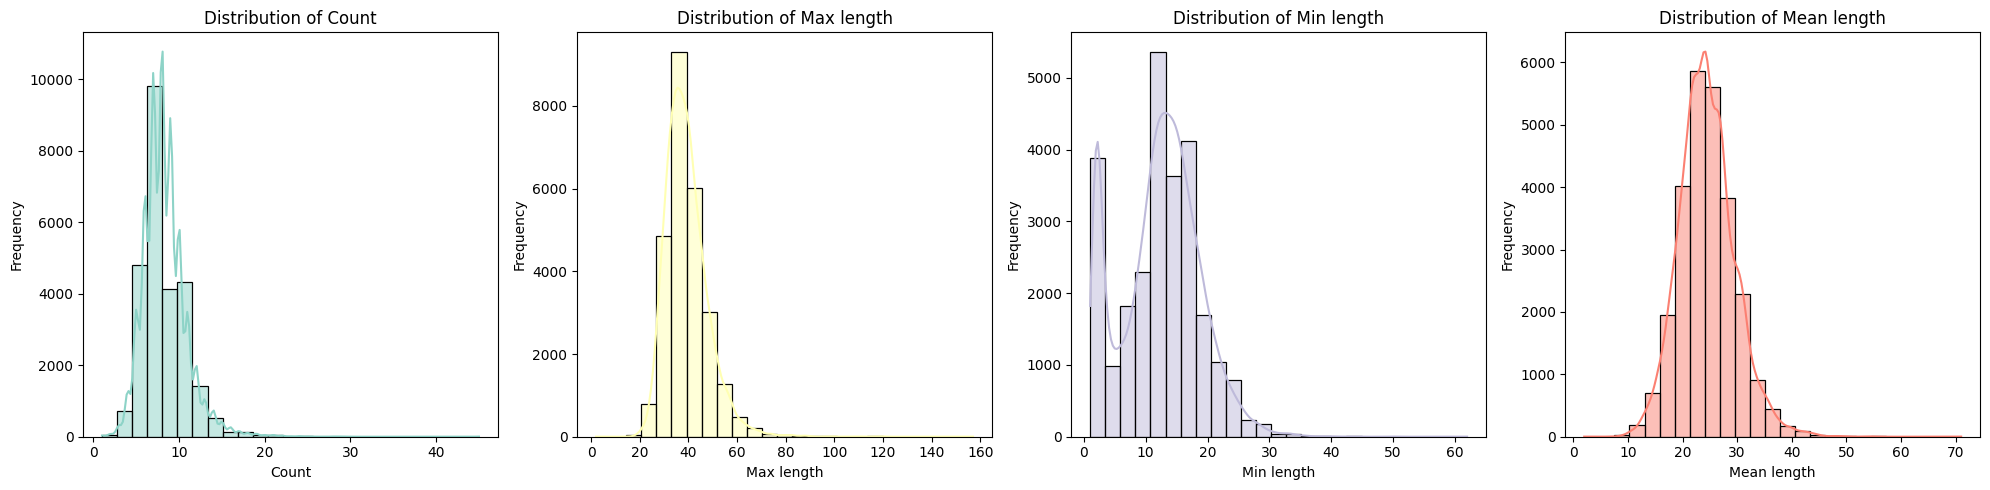

In [ ]:
plot_statistics(PLOS_laysumm_sentence_stats)

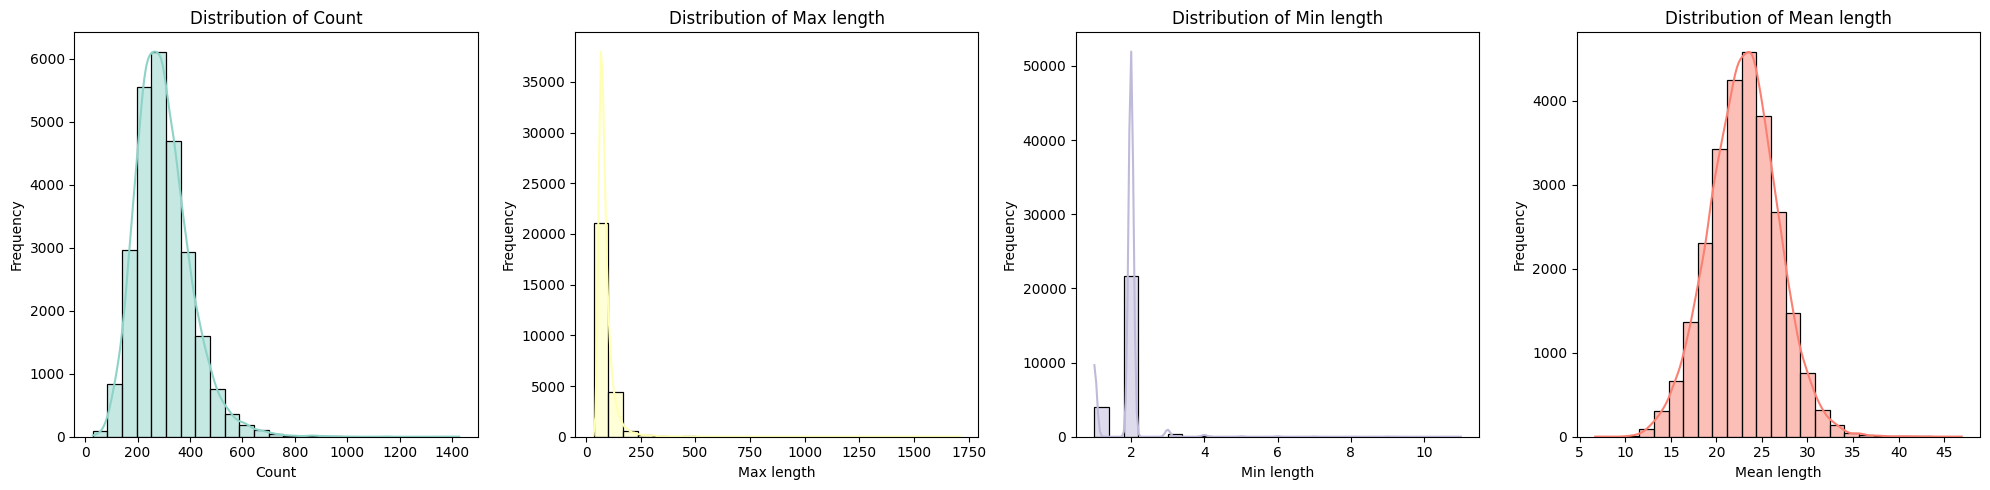

In [ ]:
plot_statistics(PLOS_article_sentence_stats)

#### Annomalies exploration

In [ ]:
# Exploring sentence length equals to 1

PLOS_laysumm_sentence_stats[PLOS_laysumm_sentence_stats['min_length'] == 1]

,count,max_length,min_length,mean_length
40,11.0,33.0,1.0,18.090909
670,8.0,44.0,1.0,21.625000
2621,7.0,44.0,1.0,29.428571
3647,12.0,41.0,1.0,19.166667
6106,13.0,33.0,1.0,18.076923
7160,7.0,38.0,1.0,25.428571
7197,8.0,88.0,1.0,24.625000
10885,8.0,52.0,1.0,24.750000
11457,5.0,38.0,1.0,22.200000
12031,20.0,59.0,1.0,12.050000


In [ ]:
sentences = sent_tokenize(df[PLOS]['lay_summary'].iloc[40])
min_length_sentence = min(sentences, key=lambda x: len(x.split()))

In [ ]:
min_length_sentence

'.'

In [ ]:
sentences

['Despite having immense medical importance , still vaccine , chemoprophylactic , or effective therapeutic measures are not commercially available for chikungunya .',
 'Only strict attention to good infection control practices may prevent CHIKV infection .',
 'The pathogenic properties of CHIKV necessitate the development of an efficient antiviral therapies .',
 'Four siRNAs each , targeting the E2 and ns1 genes of chikungunya were designed and evaluated for their efficiency in inhibiting CHIKV growth in in vitro and in vivo model systems .',
 'Efficiency of these siRNAs in controlling CHIKV replication in vitro and in vivo was assessed by the real time PCR , IFA and plaque assay .',
 'Chik-1 and Chik-5 siRNA ids efficiently inhibited CHIKV replication in the virus-infected Vero-E6 cells and mice .',
 'CHIKV replication was completely inhibited in the virus-infected mice when administered 72 hours post infection ( p .',
 'i . )',
 '.',
 'The combination of Chik-1 and Chik-5 siRNAs exhi

In [ ]:
# Exploring sentence length equal to a very high number

eLife_article_sentence_stats[eLife_article_sentence_stats['max_length'] == 1380]

,count,max_length,min_length,mean_length
27835,946.0,1380.0,2.0,18.016913


In [ ]:
sentences = sent_tokenize(df['article'].iloc[27835])
max_length_sentence = max(sentences, key=lambda x: len(x.split()))

In [ ]:
max_length_sentence

'017yYB numberGenotype6637anup82::NUP82-3sfGFP:kanMX4; pPCM14 ( 224 tetO-REC-URA3-CEN-REC-LEU2 ) ; PURA3-TETR-mCherry:kanMX4; his3::PGAL-REC:HIS3; trp1::GAL4-EBD:TRP1; ade2-10110 , 071 , 10 , 072 , 10 , 073afob1::FOB1-yeGFP:hphNT1; pPCM14 ( 224 tetO-REC-URA3-CEN-REC-LEU2 ) ; PURA3-TETR-mCherry:kanMX4; his3::PGAL-REC:HIS3; trp1::GAL4-EBD:TRP1; ade2-101; clones 1-36271anup82::NUP82-yeGFP:natNT2; pPCM14 ( 224 tetO-REC-URA3-CEN-REC-LEU2 ) ; PURA3-TETR-mCherry:kanMX4; his3::PGAL-REC:HIS3; trp1::GAL4-EBD:TRP1; ade2-1019038anup49::NUP49-yeGFP:hphNT1; pPCM14 ( 224 tetO-REC-URA3-CEN-REC-LEU2 ) ; PURA3-TETR-mCherry:kanMX4; his3::PGAL-REC:HIS3; trp1::GAL4-EBD:TRP1; ade2-1019415 , 9416 , 10 , 454anup49::NUP49-yeGFP:hphNT1; bud6::natNT2; pPCM14 ( 224 tetO-REC-URA3-CEN-REC-LEU2 ) ; PURA3-TETR-mCherry:kanMX4; his3::PGAL-REC:HIS3; trp1::GAL4-EBD:TRP1; ade2-101 clones 1-34221apPCM14 ( 224 tetO-REC-URA3-CEN-REC-LEU2 ) ; spc42::SPC42-CFP:kanMX4; leu2::TETR-GFP:LEU2; his3::PGAL-REC:HIS3; trp1::GAL4-EBD:TR

In [ ]:
print_sample(df, idx=27835)

**Conclusion**: we can see that sentences with minimum length equal to 1 are composed by a single dot or number. On the other hand, maximum length sentences with very high length correspond to tables of data, ennumerations, and other parts that are not separated by a dot. For the explored example, we can see it in the original article:  https://doi.org/10.7554/eLife.03790 .

In [ ]:
del eLife_article_sentence_stats, eLife_laysumm_sentence_stats, PLOS_article_sentence_stats, PLOS_laysumm_sentence_stats

### Token-related statistics

In [ ]:
eLife_article_word_stats = df[eLife]['article'].apply(compute_word_stats).apply(pd.Series)
eLife_abstract_word_stats = df[eLife]['article'].apply(extract_abstract).apply(compute_word_stats).apply(pd.Series)
eLife_laysumm_word_stats = df[eLife]['lay_summary'].apply(compute_word_stats).apply(pd.Series)

In [ ]:
print("For eLife articles: \n")
print(" * Mean Number of Words:", eLife_article_word_stats['count'].mean())
print(" * Maximum Word Length:", eLife_article_word_stats['max_length'].max())
print(" * Mean Word Length:", eLife_article_word_stats['mean_length'].mean())

print("\n\nFor eLife abstracts: \n")
print(" * Mean Number of Words:", eLife_abstract_word_stats['count'].mean())
print(" * Maximum Word Length:", eLife_abstract_word_stats['max_length'].max())
print(" * Mean Word Length:", eLife_abstract_word_stats['mean_length'].mean())

print("\n\nFor eLife lay summaries: \n")
print(" * Mean Number of Words:", eLife_laysumm_word_stats['count'].mean())
print(" * Maximum Word Length:", eLife_laysumm_word_stats['max_length'].max())
print(" * Mean Word Length:", eLife_laysumm_word_stats['mean_length'].mean())


For eLife articles: 

 * Mean Number of Words: 8830.048847536476
 * Maximum Word Length: 3253.0
 * Mean Word Length: 5.033383138851355


For eLife abstracts: 

 * Mean Number of Words: 156.94692323958554
 * Maximum Word Length: 32.0
 * Mean Word Length: 5.787859840384429


For eLife lay summaries: 

 * Mean Number of Words: 353.14868105515586
 * Maximum Word Length: 26.0
 * Mean Word Length: 5.075905209414408


In [ ]:
PLOS_article_word_stats = df[PLOS]['article'].apply(compute_word_stats).apply(pd.Series)
PLOS_abstract_word_stats = df[PLOS]['article'].apply(extract_abstract).apply(compute_word_stats).apply(pd.Series)
PLOS_laysumm_word_stats = df[PLOS]['lay_summary'].apply(compute_word_stats).apply(pd.Series)

In [ ]:
print("For PLOS articles: \n")
print(" * Mean Number of Words:", PLOS_article_word_stats['count'].mean())
print(" * Maximum Word Length:", PLOS_article_word_stats['max_length'].max())
print(" * Mean Word Length:", PLOS_article_word_stats['mean_length'].mean())

print("\n\nFor PLOS abstracts: \n")
print(" * Mean Number of Words:", PLOS_abstract_word_stats['count'].mean())
print(" * Maximum Word Length:", PLOS_abstract_word_stats['max_length'].max())
print(" * Mean Word Length:", PLOS_abstract_word_stats['mean_length'].mean())

print("\n\nFor PLOS lay summaries: \n")
print(" * Mean Number of Words:", PLOS_laysumm_word_stats['count'].mean())
print(" * Maximum Word Length:", PLOS_laysumm_word_stats['max_length'].max())
print(" * Mean Word Length:", PLOS_laysumm_word_stats['mean_length'].mean())

For PLOS articles: 

 * Mean Number of Words: 6024.461754973185
 * Maximum Word Length: 2727.0
 * Mean Word Length: 5.1413113197691285


For PLOS abstracts: 

 * Mean Number of Words: 247.49880187136282
 * Maximum Word Length: 36.0
 * Mean Word Length: 5.592644105006996


For PLOS lay summaries: 

 * Mean Number of Words: 180.63937435465982
 * Maximum Word Length: 29.0
 * Mean Word Length: 5.573340014788239


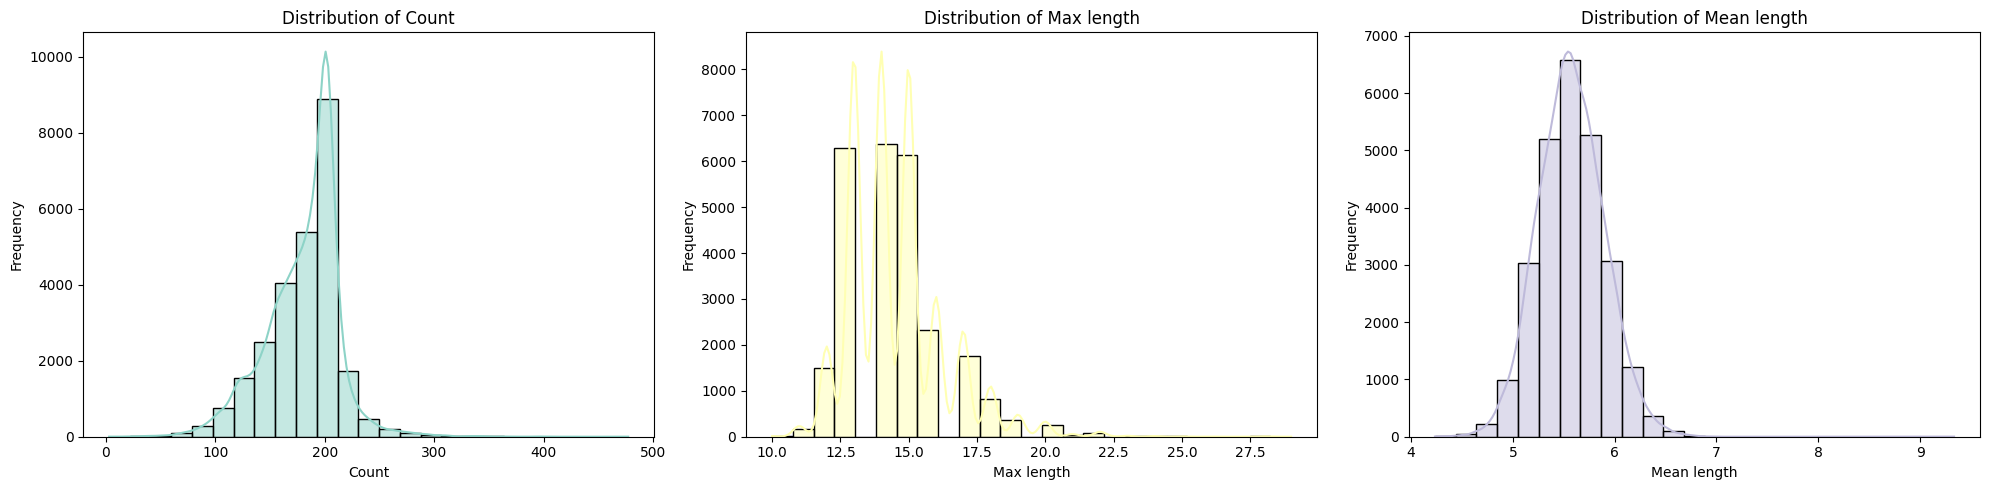

In [ ]:
plot_statistics(PLOS_laysumm_word_stats)

#### Unique words counting

In [ ]:
token_freqs = df['article'].apply(extract_unique_words)
laysumm_token_freqs = df['lay_summary'].apply(extract_unique_words)

In [ ]:
token_freqs_dict = FreqDist()

for word_freq in token_freqs:
  token_freqs_dict.update(word_freq)

for word_freq in laysumm_token_freqs:
  token_freqs_dict.update(word_freq)

In [ ]:
print(f"The number of unique tokens in the dataset is: {len(token_freqs_dict.keys())}")

The number of unique tokens in the dataset is: 960690


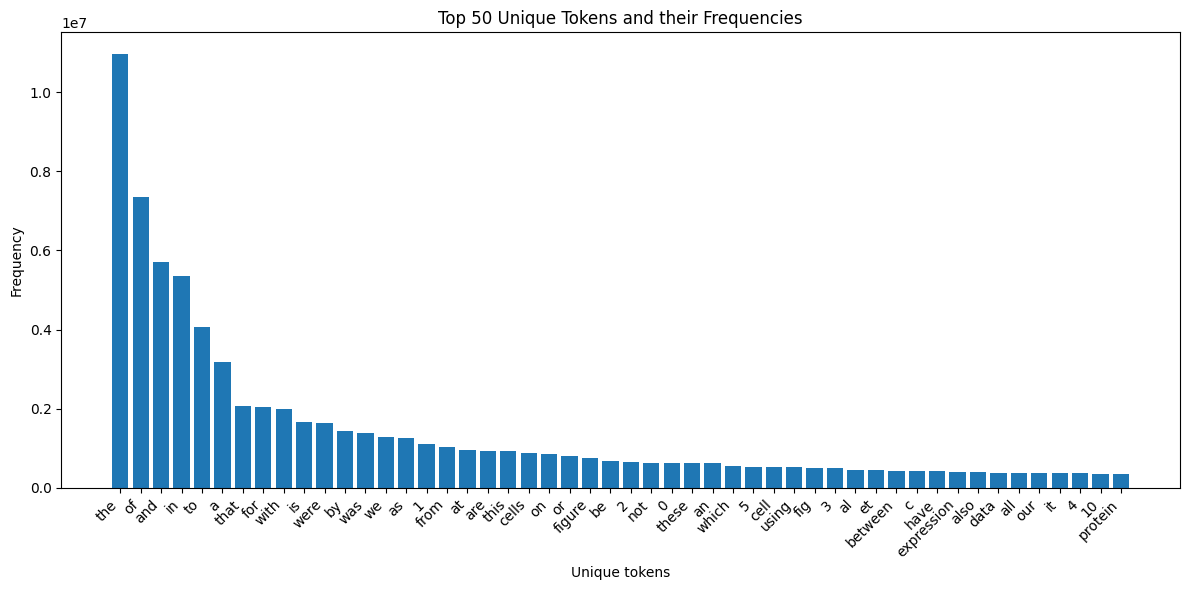

In [ ]:
top_words = token_freqs_dict.most_common(50)

words = [word_freq[0] for word_freq in top_words]
frequencies = [word_freq[1] for word_freq in top_words]

plt.figure(figsize=(12, 6))
plt.bar(words, frequencies)
plt.xlabel('Unique tokens')
plt.ylabel('Frequency')
plt.title('Top 50 Unique Tokens and their Frequencies')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

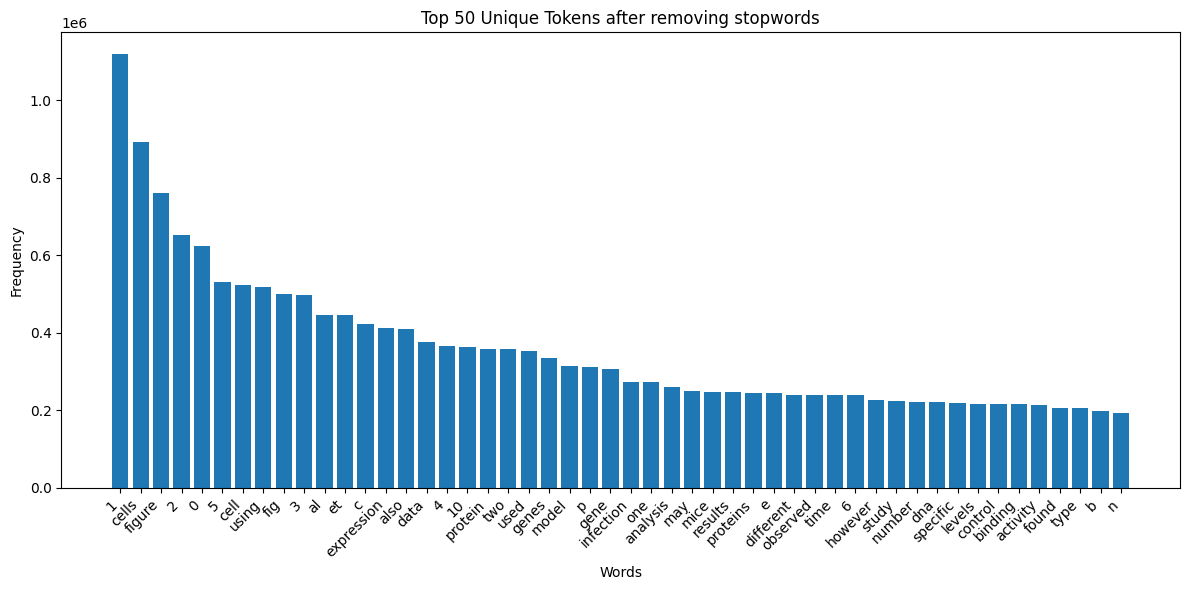

In [ ]:
# Remove stop words and check unique words again

stop_words = set(stopwords.words('english'))

filtered_freqs_dict = {word: freq for word, freq in token_freqs_dict.items() if word not in stop_words}

top_words = FreqDist(filtered_freqs_dict).most_common(50)

words = [word_freq[0] for word_freq in top_words]
frequencies = [word_freq[1] for word_freq in top_words]

plt.figure(figsize=(12, 6))
plt.bar(words, frequencies)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 50 Unique Tokens after removing stopwords')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## Keyword analysis

### eLife

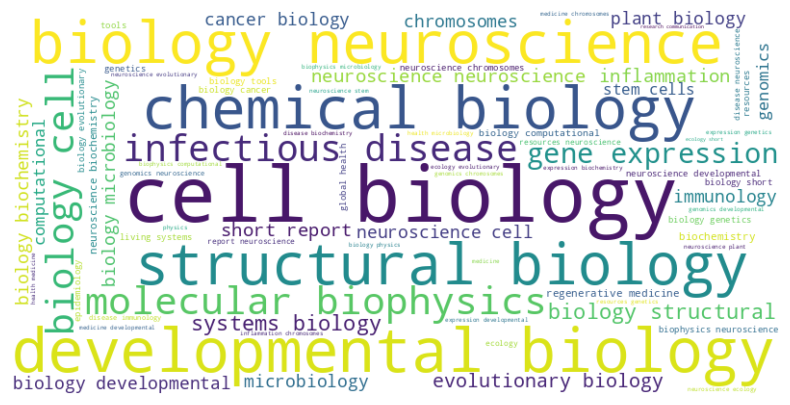

In [ ]:
all_keywords = [keyword for sublist in df[eLife]['keywords'].dropna() for keyword in sublist]

keywords_text = ' '.join(all_keywords)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(keywords_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### PLOS

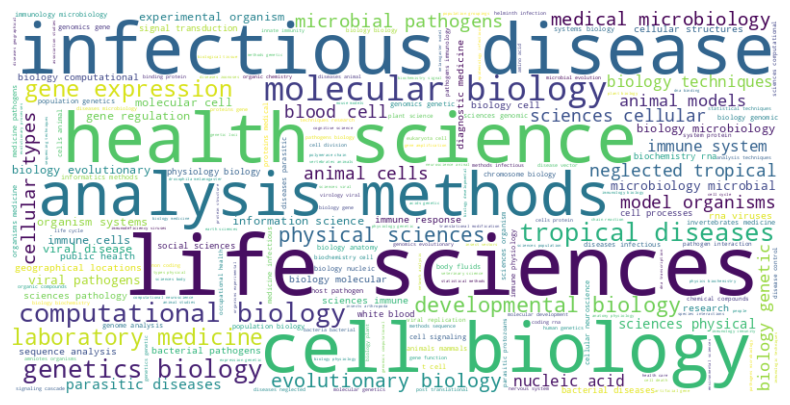

In [ ]:
all_keywords = [keyword for sublist in df[PLOS]['keywords'].dropna() for keyword in sublist]

keywords_text = ' '.join(all_keywords)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(keywords_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()